# Промежуточное моделирование для Модели микроуровневого стресс-тестирования (на уровне отдельных компаний-застройщиков) - "Банкротства застройщиков"

<span style="font-color:blue; font-size:large"><i>Блокнот для расчет и оценки промежуточных моделей.</i></span>

## Алгоритм работы
 
  1. **Чтение данных из базы данных (таблицы SPARK, LOAN и BANKRP).** Данные читаются посредством запросов, созданных на этапе созднания базы данных. Первичный счет показателей осуществляется в этих запросах. При желании можно загрузить данные непосредственно из таблиц, для этого надо поменять название таблицы в строке запроса, в коде, в данном блокноте. Однако вычисления на стороне базы данных несколько быстрее, чем вычисления в коде.   
  2. **Чтение данных из "Долгосрочной модели".** Эти данные предполагается в будущем моделировать в Питоне, однако в настоящий момент они берутся из модели в файле Excel. Эти данные необходимы для построения и расчета промежуточных под-моделей, используемых в основном блоке расчета модели банкротств  
  3. **Построение и расчет промежуточных под-моделей**. Под-модели используются в качестве поставщиков данных для основной модели
  4. **Формирование входного тренда для основной модели** Результаты промежуточного моделирования сводятся в один фрейм, этот фрейм чистится и форматируется под исходный формат данных для основной модели. Подготовленный фрейм записывается в рабочую базу данных
  
## Структура блокнота

- Первый блок: общие константы, создание коннекта к рабочей базе банных
- Второй блок: чтение данных из Долгосрочной модели и базы данных долгосрочной модели. Данные читаются из Excel файла (прогноз) и sqlite3 файла (факт, база данных), используются в разных моделях этого блокнота. 
- Третий блок: модели ROA и Z_A
  - Чтение и подготовка данных для моделирования ROA и Z_A
  - Оценка и расчет моделей ROA и Z_A
- Четвертый блок: модель Ставки по кредитам
- Пятый блок: форматирование фрейма конечных данных для записи в рабочую базу. Фрейм создается из фрейма результатов моделировани, фактических полей базы SPARK и таблицы фактических банкротств компаний
  - Формирование структуры данных по компаниям и годам
  - Продление полей на прогнозный период
  - Заполнение пропусков, удаление "пустышек" и дублирования
  - Установка флага фактических банкротств Y (данные читаются из рабочей базы)
- Окончание: сохранение результата в рабочей базе

In [190]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from os import path, getcwd
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import sqlalchemy as sa
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import patsy
import datetime as dt

# общие константы и функции
idx=pd.IndexSlice # объект для индексации мультииндексного фрейма
strDB_path=path.join('..', 'DB', 'bankrp.sqlite3')
strDB_YEAR_path=path.join('..', 'DB', 'year.sqlite3')

# константы базы данных SQLite3
strNOZA_table='noza' # название таблицы NOZA в базе данных SQLite
strNOZA_agg='noza_ag' # название рабочего  представления для таблицы NOZA в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)
strNOZA_data_pass='noza_columns' # таблица с названиями колонок для таблицы noza
strSPARK_table='spark' # название таблицы SPARK в базе данных SQLite
strSPARK_agg='spark_ag' # название рабочего  представления для таблицы SPARK в базе данных SQLite (ROA из базы)
strSPARK_agg_roa_calc='spark_ag_roa_calc' # название рабочего  представления для таблицы SPARK (ROA считаем)
strSPARK_data_pass='spark_columns' # таблица с названиями колонок для таблицы SPARK
strLOAN_table='loan' # название таблицы LOAN в базе данных SQLite
strLOAN_data_pass='loan_columns' # таблица с названиями колонок для таблицы loan
strLOAN_agg='loan_agg' # название рабочего  представления для таблицы LOAN в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)
strBNKRPT_table='bankrp' # название таблицы с фактическими банкротствами
strModeLDATA_table='model_data'  # название таблицы с входными данными для основной модели "Банкротства застройщиков"

strLEND_PRC_table='lending'
strLEND_RES_table='lending_reserv'
# ------------

# пути и константы для данных из Excel-версии модели и базы данных
strModelSource=path.join('..', 'DB', 'SRC', 'Долгосрочная модель.xlsx')
strMargaSheet='Новостройки'
strModelSheet='Модель'
strStrojKomplex='Стройкомплекс'
#---------------

strMD='''
<div class="alert alert-block alert-success">
<b>База данных - {bd_path}<br>
<a href="{bankrupt_prob_DB}?DATABASE={bd_path}" target="_blank">Работа с базой данных для этой модели</a></b><br>
</div>
'''.format(bankrupt_prob_DB='bankrupt_prob_DB.ipynb', bd_path=strDB_path)
md(strMD)


<div class="alert alert-block alert-success">
<b>База данных - ../DB/bankrp.sqlite3<br>
<a href="bankrupt_prob_DB.ipynb?DATABASE=../DB/bankrp.sqlite3" target="_blank">Работа с базой данных для этой модели</a></b><br>
</div>


In [191]:
conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_path)) # connection к рабочей базе данных
conYear = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_YEAR_path)) # connection к базе данных Долгосрочной модели

# Чтение данных из Долгосрочной модели

Данные используются в разных моделях блокнота.

<div class="alert alert-block alert-info">
    Фактические даные - из базы данных с годовыми рядами - файл ./DB/year.sqlite3<br>
    Прогнозные данные - excel-файл с долгосрочной моделью - в каталоге ./DB/SRC<br>
    Чтобы использовать последнюю версию модели сохранить  файл с моделью с расширением xlsx и загрузить его по этому пути
    
    Данные используются для расчета под-моделей: моделирования медианной по отрасли рентабельности застройщиков и медианной по отрасли задолженности
</div>

- Читаем данные из базы данных (sqlite3). 
- Читаем данные из Excel файла Долгосрочной модели (xlsx). Это прогнозные данные, читаются из двух листов и разных строк.
- Объединяем прогнозные и фактические данные в один фрейм. Разные модели этого блокнота используют разные колонки полученного фрейма


### Читаем фактические данные из базы данных (`sqlite3`)

считаем маржу как $marga = Средняя\_фактическая\_удельная\_стоимость\_жилья / цена\_ДДУ\_абсолютная$

In [192]:
tpl_codes=(65, 69, 116, 131, 52, 238, 240, 202) # коды рядов из базы данных, т.е. читаем имено эти ряды - порядок важен!!!
tpl_names=('I_phyvol_issue', 'Chng_avrg_num_empls', 'I_nom_prices_sec_market', 'CPI', 'key_rate', 'GDP_grow') # порядок важен!!!

strSQL_year_SELECT='select * from datas where code in {codes}'.format(codes=tpl_codes)

pdfYear=pd.read_sql(strSQL_year_SELECT, con=conYear).set_index(['date', 'code']).unstack(level=1)
pdfYear.columns=[c[1] for c in pdfYear.columns]

# pdfYear['marga']=pdfYear[52]/pdfYear[131] # маржа = стоимость строительства / цена ДДУ
pdfYear['marga']=pdfYear[131]/pdfYear[52] # маржа = цена ДДУ / стоимость строительства  

pdfYear.rename(columns=dict(zip( (cd for cd in tpl_codes if cd not in (52, 131) ), tpl_names)), inplace=True)

lst_work_columns=list(tpl_names)+['marga',] # рабочие поля - используется в дальнейшем

pdfYear=pdfYear[lst_work_columns]
pdfYear.index=pdfYear.index.astype(int)
pdfYear

,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,CPI,key_rate,GDP_grow,marga
date,,,,,,,
2004,1.101,NaN,NaN,1.108812,0.135200,1.071759,1.493010
2005,1.132,NaN,NaN,1.127055,0.129800,1.063762,1.531764
2006,1.181,NaN,1.3684,1.096830,0.088942,1.081534,1.663389
2007,1.182,1.029933,1.3389,1.089881,0.075126,1.085351,1.884944
2008,1.128,1.064991,1.1954,1.141048,0.081291,1.052480,1.716113
2009,0.868,0.923699,0.9455,1.116977,0.113100,0.921791,1.434751
2010,1.050,0.960931,0.9843,1.068508,0.080300,1.045037,1.343579
2011,1.051,1.007171,1.0827,1.084634,0.081200,1.042642,1.137379
2012,1.025,1.016925,1.1524,1.050667,0.080700,1.036559,1.210883


### Читаем прогнозные данные из файла Excel (долгосрочная модель - `Долгосрочная модель.xlsx`)

<div class="alert alert-block alert-warning">
    <b>Файл должен быть в формате XLSX</b>
</div>

Исходные данные:  
- **Изменение среднесписочной численности работников** (лист Модель, строка 493; или лист Стройкомплекс, строка 13; фактические данные из year.sqlite3, код 69)
- **Индекс физобъема выпуска** (лист Модель, строка 489; или лист Стройкомплекс, строка 6; фактические данные из year.sqlite3, код 65))
- **Маржа прибыли застройщиков** (лист Новостройки, строка 10)
- **Индексы номинальных цен на рынке жилья, на вторичном рынке** (лист Модель, строка 687, делить на 100; фактические данные из year.sqlite3, код 116))

<div class="alert alert-block alert-warning">
    <b>Выполнение следующей ячейки занимает много времени</b>
</div>

In [193]:
# для чтения данных из листа Модель
pdfXLS_model=pd.read_excel(strModelSource, sheet_name=strModelSheet, usecols='B, G:AZ', 
                           skiprows=[i for i in range(1500) if i not in [2, 686, 492, 488, 1038, 1042, 995]], index_col=0)
pdfXLS_model=pdfXLS_model.T
pdfXLS_model.columns=[c.strip() for c in pdfXLS_model.columns]
print('Прочитано из файла ексель', pdfXLS_model.shape)

# print(pdfXLS_model.head())
#==========================
# для чтения данных из листа Стройкомплекс
# pdfXLS_strojK=pd.read_excel(strModelSource, sheet_name=strStrojKomplex, usecols='A, F:BZ', 
#                            skiprows=[i for i in range(1500) if i not in [1, 5, 12]], index_col=0)

# pdfXLS_model=pdfXLS_strojK.T
# print(pdfXLS_model)
# #=========================================

print('Читаем маржу из листа Новостройки, добавляем во фрейм', end='...')
pdfXLS_model['marga']=pd.read_excel(strModelSource, sheet_name=strMargaSheet, usecols='B, K:AZ',
                      skiprows=[i for i in range(255) if i not in [0, 9, 10]], 
                      index_col=0).loc['маржа прибыли застройщиков'] / 100
print('сделано - ', pdfXLS_model.shape)
print('Переименование колонок для удоства использования', end='...')

dct_Excel_names={'Индекс физобъема выпуска':'I_phyvol_issue',   'Изменение среднесписочной численности работников':'Chng_avrg_num_empls',  
                       'на вторичном рынке':'I_nom_prices_sec_market', 'ИПЦ, в среднем за год':'CPI', 
                       'Ключевая ставка, в среднем за год':'key_rate', 'Темпы роста реального ВВП':'GDP_grow'}

# print(pdfXLS_model.columns)

pdfXLS_model.rename(columns=dct_Excel_names, inplace=True)

print('сделано')
pdfXLS_model=pdfXLS_model.dropna(how='all')
pdfXLS_model.index=pdfXLS_model.index.astype(int)
pdfXLS_model

Прочитано из файла ексель (28, 6)
Читаем маржу из листа Новостройки, добавляем во фрейм...сделано -  (28, 7)
Переименование колонок для удоства использования...сделано


,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,GDP_grow,CPI,key_rate,marga
2009,NaN,NaN,0.945500,0.921791,1.116977,0.113100,1.434751
2010,1.050000,0.960931,0.984300,1.045037,1.068508,0.080300,1.343579
2011,1.051000,1.007171,1.082700,1.042642,1.084634,0.081200,1.137379
2012,1.025000,1.016925,1.152400,1.040241,1.050667,0.080700,1.210883
2013,1.001000,0.987682,1.078200,1.017554,1.067608,0.073500,1.210797
2014,0.977000,0.978279,1.062000,1.007363,1.078043,0.078598,1.148896
2015,0.961000,0.960882,0.987700,0.980273,1.155546,0.126484,1.179112
2016,0.979000,0.973983,0.958900,1.001937,1.070664,0.105847,1.164349
2017,0.989000,0.973601,0.976600,1.018258,1.036931,0.091389,1.214532
2018,1.063000,0.992443,1.015800,1.025363,1.028759,0.074198,1.299932


### Объединение фактических и прогнозных (из долгосрочной модели) значений

In [194]:
# pdfXLS_model=pdfXLS_model.append(pdfYear).reset_index().drop_duplicates('index', keep='last').sort_values('index').rename(columns={'index':'year'}).set_index('year')[lst_work_columns]
# print(pdfXLS_model)

pdfModel=pdfYear.combine_first(pdfXLS_model)
pdfModel.index.name='year'

pdfModel.dropna()


,CPI,Chng_avrg_num_empls,GDP_grow,I_nom_prices_sec_market,I_phyvol_issue,key_rate,marga
year,,,,,,,
2007,1.089881,1.029933,1.085351,1.338900,1.182000,0.075126,1.884944
2008,1.141048,1.064991,1.052480,1.195400,1.128000,0.081291,1.716113
2009,1.116977,0.923699,0.921791,0.945500,0.868000,0.113100,1.434751
2010,1.068508,0.960931,1.045037,0.984300,1.050000,0.080300,1.343579
2011,1.084634,1.007171,1.042642,1.082700,1.051000,0.081200,1.137379
2012,1.050667,1.016925,1.036559,1.152400,1.025000,0.080700,1.210883
2013,1.067608,0.987682,1.017854,1.078200,1.001000,0.073500,1.210797
2014,1.078043,0.978279,1.007386,1.062000,0.977000,0.078598,1.148896
2015,1.155546,0.960882,0.980452,0.987700,0.961000,0.126484,1.179112


# Построение и расчет промежуточных моделей

<div class="alert alert-block alert-info">
    <b>
    X - предикторы фактических значений<br>
    x - предикторы прогнозных значений<br>
    Y - известные объясняемые значения<br>
    y - прогнозные объясняемые значения<br>
    </b>
</div>   

   
## Подготовка данных для моделирования моделей ROA и Z_A

### Чтение данных из рабочей базы данных

Даные из таблицы NOZA не используются.  

Данные из таблицы SPARK читаются запросом spark_ag. В запросе расчитывается показатель Z_A: 
`модуль((Кредиторская задолженность - Дебиторская задолженность) / Активы всего)`.

Показатель ROA берется из базы данных, однако он так же может расчитываться по формуле `Чистая прибыль/Активы всего` (для этого надо использовать запрос spark_ag_roa_calc)

Данные из таблицы BANKRP читаются полностью. В блокноте выбираются только ИНН, существующие в таблице SPARK.

In [195]:
# strSELECT_NOZA='select * from {noza_table}'.format(noza_table=strNOZA_agg)
strSELECT_spark='select * from {spark_table}'.format(spark_table=strSPARK_agg)

pdfSPARK=pd.read_sql(strSELECT_spark, con=conWork)
pdfSPARK.replace({None:np.nan}, inplace=True)
pdfSPARK['Cancel_date']=pd.to_datetime(pdfSPARK['Cancel_date'])
print(pdfSPARK.shape)
pdfSPARK.head()

(103968, 6)


,inn,year,capital,Cancel_date,ROA,Z_A
0,3906245291,2013,NaN,NaT,NaN,NaN
1,3801132195,2013,NaN,NaT,NaN,NaN
2,5050102110,2013,10000.0,NaT,NaN,0.633592
3,7448046410,2013,NaN,NaT,NaN,NaN
4,1840032987,2013,NaN,NaT,NaN,NaN


##   `pdfSubModResult` - датафрейм с результатами расчета под-моделей

`prepare_data` - процедура подготовки данных, общая для моделей ROA и Z_A

In [196]:
# def prepare_data(pdfSP, pdfMOD, strMOD_field, lstFileds):
#     _pdf=pdfSP.groupby(by='year').agg({strMOD_field:np.median})
#     _pdf=pdfXLS_model.join(_pdf)[lstFileds+[strMOD_field,]]
#     return _pdf.dropna(), _pdf.loc[_pdf.dropna().index.max():]


def prep_XY(pdfY=None, pdfXx=None, lstXFieldNames=[]):
    pdfx=pdfXx[lstXFieldNames].dropna()
    pdfX=pdfY.join(pdfx)
    pdfx[pdfY.columns[0]]=np.nan
    return pdfX, pdfx.loc[pdfX.index[-1]:]
    
    
pdfSubModResult=pd.DataFrame(pdfModel.dropna(how='all').index.astype('int64'), columns=['year',]).set_index('year')

## Модель *Рентабельность застройщиков, медиана по отрасли  (ROA)*
<br>
<center>$\overline{ROA}$ ~ $I\_nom\_prices\_sec\_market$ + $marga$ + $1$</center>

<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Индексы номинальных цен на рынке жилья, на вторичном рынке (<i>I_nom_prices_sec_market</i>, из данных Долгосрочной модели)</li>
        <li>Маржа прибыли застройщиков (<i>marga</i>, из данных Долгосрочной модели)</li>        
    </ul><br>
    <b>Объясняемая переменная</b> - медианная по отрасли рентабельность застройщика (<i>ROA</i> датафрейма <i>pdfSPARK</i>)
</div>

In [197]:
pdfROA=pdfSPARK.groupby(by='year').agg({'ROA':np.median})
X_roa, x_roa=prep_XY(pdfXx=pdfModel, lstXFieldNames=['I_nom_prices_sec_market', 'marga'], pdfY=pdfROA)

resROA = smf.ols(formula='ROA ~ I_nom_prices_sec_market + marga', missing='drop', data=X_roa).fit()
print(resROA.summary())

                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     4.983
Date:                Thu, 03 Dec 2020   Prob (F-statistic):             0.0349
Time:                        17:54:13   Log-Likelihood:                 66.098
No. Observations:                  12   AIC:                            -126.2
Df Residuals:                       9   BIC:                            -124.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [198]:
Ym_roa=pd.DataFrame(resROA.predict(X_roa), index=X_roa.index, columns=['ROA, модель'])
y_roa=pd.DataFrame(resROA.predict(x_roa), columns=['ROA, прогноз'])

# формируем датафрейм с данными для основной модели - модели банкротств
pdfSubModResult.loc[X_roa.index, 'ROA_']=X_roa.iloc[:, 0]
pdfSubModResult.loc[y_roa.index, 'ROA_']=y_roa.iloc[:, 0]
# pdfSubModResult.dropna()

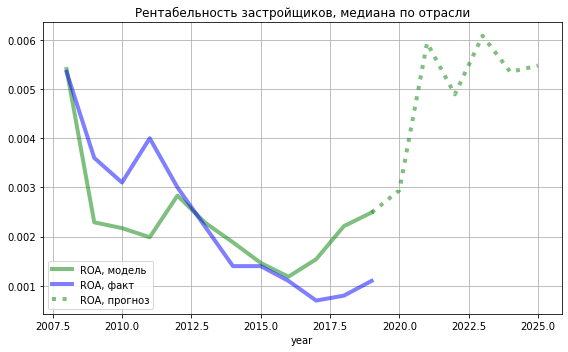

In [199]:
ax_roa=Ym_roa.plot.line(figsize=(8, 5), linewidth=4, alpha=0.5, grid=True,
         title='Рентабельность застройщиков, медиана по отрасли', color='g')

X_roa.rename(columns={'ROA':'ROA, факт'})[['ROA, факт']].plot.line(ax=ax_roa, color='b', linewidth=4, alpha=0.5)
y_roa.plot.line(ax=ax_roa, color='g', style=':', linewidth=4, alpha=0.5, grid=True)

# pdfSubModResult.dropna().plot.line(ax=ax_roa, style='.-', color='maroon', linewidth=14, alpha=0.2)
plt.tight_layout()
plt.show();

## Модель *Чистая кредиторская задолженность (по модулю), медиана по отрасли (Z_A)*
<br>
<center>$\overline{Z\_A}$ ~ $I\_phyvol\_issue_{y-1} + Chng\_avrg\_num\_empls_{y-1} + 1$</center>
<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Индекс физобъема выпуска (<i>I_phyvol_issue</i>, из данных Долгосрочной модели, с лагом 1 год)</li>
        <li>Изменение среднесписочной численности работников (<i>Chng_avrg_num_empls</i>, из данных Долгосрочной модели, с лагом 1 год))</li>        
    </ul><br>
    <b>Объясняемая переменная</b> - медианная по отрасли Чистая кредиторская задолженность (<i>Z_A</i> датафрейма <i>pdfSPARK</i>)
</div>

In [200]:
pdfZ_A=pdfSPARK.groupby(by='year').agg({'Z_A':np.median})
X_za, x_za=prep_XY(pdfXx=pdfModel, lstXFieldNames=['I_phyvol_issue', 'Chng_avrg_num_empls'], pdfY=pdfZ_A)


resZ_A = smf.ols(formula="Z_A ~ I_phyvol_issue.shift(1) + Chng_avrg_num_empls.shift(1)", 
                 missing='drop', data=X_za).fit()

print(resZ_A.summary())

                            OLS Regression Results                            
Dep. Variable:                    Z_A   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.247
Date:                Thu, 03 Dec 2020   Prob (F-statistic):              0.338
Time:                        17:54:29   Log-Likelihood:                 39.588
No. Observations:                  11   AIC:                            -73.18
Df Residuals:                       8   BIC:                            -71.98
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [201]:
Ym_za=pd.DataFrame(resZ_A.predict(X_za), index=X_za.index, columns=['Z_A, модель'])
y_za=pd.DataFrame(resZ_A.predict(x_za), columns=['Z_A, прогноз'])[:-1]

# формируем датафрейм с данными для основной модели - модели банкротств (ПОРЯДОК ВЫПОЛНЕНИЯ ВАЖЕН!!!)
pdfSubModResult.loc[y_za.index, 'Z_A_']=y_za.iloc[:, 0]
pdfSubModResult.loc[X_za.index, 'Z_A_']=X_za.iloc[:, 0]
# pdfSubModResult

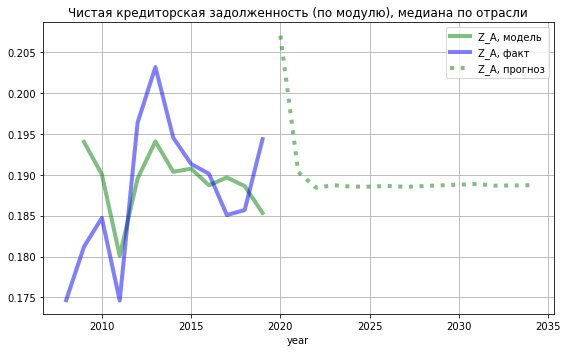

In [202]:
ax_za=Ym_za.plot.line(figsize=(8, 5), linewidth=4, alpha=0.5, grid=True,
         title='Чистая кредиторская задолженность (по модулю), медиана по отрасли', color='g')
X_za.rename(columns={'Z_A':'Z_A, факт'})[['Z_A, факт']].plot.line(ax=ax_za, color='b', linewidth=4, alpha=0.5)
y_za.plot.line(ax=ax_za, color='g', style=':', linewidth=4, alpha=0.5, grid=True)

# pdfSubModResult['Z_A_'].dropna().plot.line(ax=ax_za, color='grey', linewidth=14, alpha=0.3)

plt.tight_layout()
plt.show();

## Модель *Ставка по кредитам*

### Читаем данные из рабочей базы

Данные из таблицы LOAN читаются запросом loan_agg. Расчеты выполняются в блокноте.   
Данные из таблиц LENDING и LANDING_RESERV читаем из таблиц напрямую, расчеты в блокноте

### Читаем таблицу loan и считаем среднюю кредитную ставку за год (Y)

In [203]:
strSELECT_LOAN='select * from {loan_table}'.format(loan_table=strLOAN_agg)

pdfLOAN=pd.read_sql(strSELECT_LOAN, con=conWork)

pdfLOAN['date']=pd.to_datetime(pdfLOAN['date'], format='%Y-%m-%d')
pdfLOAN['loan_nonfin']=pdfLOAN['loan_nonfin'].astype(float)

pdfLOAN=pdfLOAN.set_index('date').groupby(by=pd.Grouper(freq='Y'))['loan_nonfin'].mean()
pdfLOAN.index=pdfLOAN.index.year
pdfLOAN.name='LOAN'
pdfLOAN

date
2011     8.450000
2012     9.100000
2013     9.466667
2014    11.135000
2015    15.716667
2016    12.592500
2017    10.560000
2018     8.866667
2019     8.753333
2020     7.011111
Name: LOAN, dtype: float64

### Средний фактический уровень РВПС по ссудам I-IV категорий качества, в % от ссудной задолженности (RVPS)

Расчеты выполняются в блокноте:
- по таблице lending считем доли Нестандаpтных, Сомнительных, Проблемных и Безнадежных ссуд **БЕЗ** Стандартных -$nonstandart + doubtful + problem + hopeless = 100\%$ для всех январей.
- перемножаем на соотв. показатель таблицы landing_reserv - $landing.nonstandart * landing\_reserv.nonstandart$
- считаем показатель кредитного риска - 
$\sum(landing*landing\_reserv)$ Поскольку берем данные по январям для каждого года, окончательное число это показатель предидущего - реиндексируем по `год-1`


In [204]:
strSELECT_LEND_PRC='select date, nonstandart, doubtful, problem, hopeless from {lend_prc_table}'.format(lend_prc_table=strLEND_PRC_table)
strSELECT_LEND_RES='select date, nonstandart, doubtful, problem, hopeless from {lend_res_table}'.format(lend_res_table=strLEND_RES_table)

pdfLEND_PRC=pd.read_sql(strSELECT_LEND_PRC, con=conWork, parse_dates={'date':'%d.%m.%y'}, index_col='date').sort_index()
pdfLEND_RES=pd.read_sql(strSELECT_LEND_RES, con=conWork, parse_dates={'date':'%d.%m.%y'}, index_col='date').sort_index()

# берем только январи для каждого года
pdfLEND_PRC=pdfLEND_PRC[pdfLEND_PRC.index.month==1]
pdfLEND_RES=pdfLEND_RES[pdfLEND_RES.index.month==1]

pdf_RVPS=pdfLEND_RES.mul(pdfLEND_PRC.div(pdfLEND_PRC.sum(axis=1), axis=0), axis=0).sum(axis=1).groupby(by=pd.Grouper(freq='YS')).mean()

# новый индекс: сдвиг по году year-1
pdf_RVPS.index=pdf_RVPS.index.year-1
pdf_RVPS.name='rvps'
pdf_RVPS

date
2010    16.085478
2011    15.490558
2012    11.685299
2013    10.744737
2014    12.613371
2015    14.052372
2016    14.883957
2017    17.076457
2018    16.561299
2019    15.513822
Name: rvps, dtype: float64

### Готовим данные и оцениваем модель

- Делаем полный фрейм `x` модели (X и x вместе, факт + прогнозный период)

- Корректируем `key_rate` значениями `rvps`:   $RATE\_CORRECT = \frac {(key\_rate \cdot 100) \cdot rvps}{100}$ 

- Переводим значения ИПЦ:   $ CPI_{corr} = (CPI-1) \cdot 100 $

- Оцениваем модель

<br>
<center>$\overline{LOAN}$ ~ $CPI_{corr} + RATE\_CORRECT$</center>
<div class="alert alert-block alert-info">
    <b>Предикторы:</b>
    <ul>
        <li>Ключевая ставка (с середины 2013 г.; до середины 2013 года - ставка РЕПО), скорректированная на `Средний фактический уровень РВПС по ссудам I-IV категорий качества, в % от ссудной задолженности (<i>RATE_CORRECT</i>)</li>        
        <li>ИПЦ, в среднем за год (<i>CPI</i>)</li>
    </ul><br>
    <b>Объясняемая переменная</b> - Средневзвешенная ставка по рублевым кредитам предприятиям (<i>loan</i> датафрейма <i>pdfLOAN</i>)
</div>

In [205]:
pdfLoanXx=pdfModel[['CPI', 'key_rate']].dropna().join(pdf_RVPS).ffill().dropna()

pdfLoanXx['rate_correct']=(pdfLoanXx['key_rate']*100*pdfLoanXx['rvps'])/100
pdfLoanXx['CPI']=(pdfLoanXx['CPI']-1)*100

X_loan, x_loan=prep_XY(pdfXx=pdfLoanXx, 
                   lstXFieldNames=['CPI', 'rate_correct', 'key_rate', 'rvps'], pdfY=pd.DataFrame(pdfLOAN))

resLOAN = smf.ols(formula="LOAN ~ CPI +  rate_correct - 1", 
                 missing='drop', data=X_loan).fit()

# resLOAN = smf.ols(formula="LOAN ~ CPI + (key_rate*rvps)  - 1", 
#                  missing='drop', data=X_loan).fit()

print(resLOAN.summary())

                                 OLS Regression Results                                
Dep. Variable:                   LOAN   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              218.5
Date:                Thu, 03 Dec 2020   Prob (F-statistic):                    1.04e-07
Time:                        17:54:47   Log-Likelihood:                         -17.550
No. Observations:                  10   AIC:                                      39.10
Df Residuals:                       8   BIC:                                      39.70
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [206]:
Ym_loan=pd.DataFrame(resLOAN.predict(X_loan), index=X_loan.index, columns=['LOAN, модель'])
y_loan=pd.DataFrame(resLOAN.predict(x_loan), columns=['LOAN, прогноз'])[:-1]

# формируем датафрейм с данными для основной модели - модели банкротств (ПОРЯДОК ВЫПОЛНЕНИЯ ВАЖЕН!!!)
pdfSubModResult.loc[y_loan.index, 'LOAN_']=y_loan.iloc[:, 0]
pdfSubModResult.loc[X_loan.index, 'LOAN_']=X_loan.iloc[:, 0]

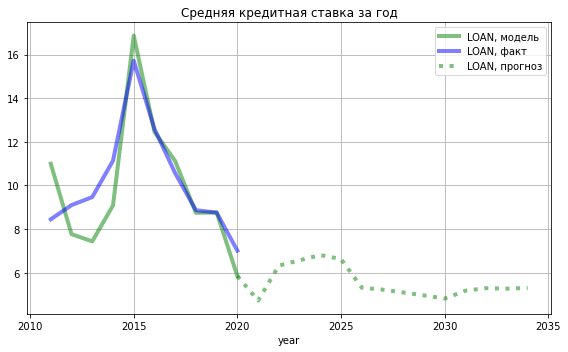

In [207]:
ax_loan=Ym_loan.plot.line(figsize=(8, 5), linewidth=4, alpha=0.5, grid=True,
         title='Средняя кредитная ставка за год', color='g')
X_loan.rename(columns={'LOAN':'LOAN, факт'})[['LOAN, факт']].plot.line(ax=ax_loan, color='b', linewidth=4, alpha=0.5)
y_loan.plot.line(ax=ax_loan, color='g', style=':', linewidth=4, alpha=0.5, grid=True)

plt.tight_layout()
plt.show();

# Подготовка данных для основной модели

Для моделирования банкротств предприятий (основная модель) используются следующие поля:  
  - ROA (рентабельность, моделируется)
  - Z_A (чистая кредиторская задолженность, моделируется)
  - LOAN (моделируется)
  - capital (уставной капитал, из базы данных SPARK)
  - Y - фактические банкротства, флаг. Y=1 означает, что в этом году предприятие обанкротилось (данные из рабочей базы, таблица strBNKRPT_table).   
  
Все данные - по компаниям (поле inn) и по годам (поле year). 

<div class="alert alert-block alert-info">
    <b>Алгоритм:</b>
    <ul>
        <li>Для каждой компании необходимо продлить предикторы на прогнозный период. Для этого используем данные промежуточного моделирования: медианные рентабельность и задолженость.</li>
        <li>Считаем прирост рентабельности и задолженности за год, полученными приростами "раскручиваем" соответствующие поля каждой компании (кумулятивной суммой). </li>
        <li>В поле `capital`заполняем пропуски по годам ближайшими значениями (вперед и назад).</li>
        <li>Устанавливаем `Y` - флаг банкротства - из таблицы фактических банкротств компаний. Данные для сделующих годов компаний с установленным флагом удаляются - компания прекратила существование.</li>                
    </ul><br>
    Полученный фрейм сохраняем в базе данных для последующего использования в основной модели.
</div>


### Подготовка данных - результатов промежуточных моделей

Считаем темпы и прирост медианных ROA, Z_A и LOAN. Суффиксы данных:  
  - '_' - медианое значение
  - '_t' - темпы (`pct_change`)
  - '_d' - прирост (`diff`)

В дальнейшем используется прирост, однако темпы считаются на всякий случай

In [208]:
pdf_res = pdfSubModResult.copy()
pdf_res=pdf_res.join(pdf_res.pct_change(), rsuffix='t') # считаем темпы
pdf_res=pdf_res.join(pdf_res[['ROA_', 'Z_A_', 'LOAN_']].diff(), rsuffix='d') # считаем прирост
pdf_res=pdf_res.dropna() # удаляем отсутствующие даные
iMinYear=pdf_res.index.min()
pdf_res

,ROA_,Z_A_,LOAN_,ROA_t,Z_A_t,LOAN_t,ROA_d,Z_A_d,LOAN_d
year,,,,,,,,,
2012,0.003000,0.196358,9.100000,-0.250000,0.124454,0.076923,-0.001000,0.021733,0.650000
2013,0.002200,0.203161,9.466667,-0.266667,0.034648,0.040293,-0.000800,0.006803,0.366667
2014,0.001400,0.194526,11.135000,-0.363636,-0.042504,0.176232,-0.000800,-0.008635,1.668333
2015,0.001400,0.191316,15.716667,0.000000,-0.016500,0.411465,0.000000,-0.003210,4.581667
2016,0.001100,0.190117,12.592500,-0.214286,-0.006267,-0.198780,-0.000300,-0.001199,-3.124167
2017,0.000700,0.185076,10.560000,-0.363636,-0.026518,-0.161406,-0.000400,-0.005042,-2.032500
2018,0.000800,0.185689,8.866667,0.142857,0.003315,-0.160354,0.000100,0.000614,-1.693333
2019,0.002490,0.194353,8.753333,2.112667,0.046656,-0.012782,0.001690,0.008663,-0.113333
2020,0.002941,0.207002,7.011111,0.181230,0.065081,-0.199035,0.000451,0.012649,-1.742222


### Соединение таблицы SPARK и таблицы с результатами промежуточного моделирования.

Поля с `np.nan` в моделировании не участвуют, поэтому обрезаем базу данных SPARK снизу по последнему валидному году во фрейме с модельными данными (modelResult).  
Из базы данных SPARK удаляем все строки, в которых нет либо ROA, либо Z_A данных. Дальнейшее моделирования будет происходить именно по этим данных.  
Поле `capital` растягиваем по всем данным компании (уставной капитал меняется редко, но часто, в разных годах по компании, не указывается, видимо, ошибка в данных). Растягиваем известное значение как вперед по годам, так и назад.

In [209]:
pdf_sp=pdfSPARK.loc[pdfSPARK[['ROA', 'Z_A']].dropna(how='any').index].copy()
pdf_sp=pdf_sp.sort_values(by=['inn', 'year'])
pdf_sp=pdf_sp[pdf_sp['year']>=iMinYear].set_index(['inn', 'year']) # переходим на мультииндекс

pdf_sp

capital Cancel_date     ROA       Z_A
inn        year                                          
0104014512 2014     10000.0         NaT -0.0426  0.797872
           2015     10000.0         NaT  0.0041  0.960739
           2016     10000.0         NaT  0.0015  0.255651
           2017  40000000.0         NaT  0.0523  0.190691
           2018  40000000.0         NaT  0.0011  0.178391
...                     ...         ...     ...       ...
9731012872 2013     10000.0  2019-05-08  0.0464  0.037122
           2014     10000.0  2019-05-08  0.0263  0.000756
           2015     10000.0  2019-05-08 -0.0277  0.374827
           2016     10000.0  2019-05-08  0.0002  0.301840
9909127226 2017         NaN         NaT  0.4867  0.356039

[39703 rows x 4 columns]

#### Соединяем фреймы SPARK и результаты моделирования в один

In [210]:
i_new=[ (c, i) for c in pdf_sp.columns for i in pdf_res.index]
pdf_sp=pdf_sp.unstack().reindex(columns=i_new).stack(dropna=False).join(pdf_res, how='outer')
pdf_sp
%store pdf_sp

Stored 'pdf_sp' (DataFrame)


In [108]:
pdf_sp.loc[idx[ ['9909127226', '0104014512'], :], :]

Cancel_date     ROA       Z_A     capital      ROA_      Z_A_  \
inn        year                                                                 
9909127226 2015         NaT     NaN       NaN         NaN  0.001400  0.191316   
           2016         NaT     NaN       NaN         NaN  0.001100  0.190117   
           2017         NaT  0.4867  0.356039         NaN  0.000700  0.185076   
           2018         NaT     NaN       NaN         NaN  0.000800  0.185689   
           2019         NaT     NaN       NaN         NaN  0.002490  0.194353   
           2020         NaT     NaN       NaN         NaN  0.002941  0.207002   
           2021         NaT     NaN       NaN         NaN  0.005940  0.190325   
           2022         NaT     NaN       NaN         NaN  0.004892  0.188416   
           2023         NaT     NaN       NaN         NaN  0.006084  0.188716   
           2024         NaT     NaN       NaN         NaN  0.005348  0.188548   
           2025         NaT     NaN       NaN         NaN  0.005477  0.188548   
0104014512 2015         NaT  0.0041  0.960739     10000.0  0.001400  0.191316   
           2016         NaT  0.0015  0.255651     10000.0  0.001100  0.190117   
           2017         NaT  0.0523  0.190691  40000000.0  0.000700  0.185076   
           2018         NaT  0.0011  0.178391  40000000.0  0.000800  0.185689   
           2019         NaT  0.0006  0.082383   2495000.0  0.002490  0.194353   
           2020         NaT     NaN       NaN         NaN  0.002941  0.207002   
           2021         NaT     NaN       NaN         NaN  0.005940  0.190325   
           2022         NaT     NaN       NaN         NaN  0.004892  0.188416   
           2023         NaT     NaN       NaN         NaN  0.006084  0.188716   
           2024         NaT     NaN       NaN         NaN  0.005348  0.188548   
           2025         NaT     NaN       NaN         NaN  0.005477  0.188548   

                     LOAN_     ROA_t     Z_A_t    LOAN_t     ROA_d     Z_A_d  \
inn        year                                                                
9909127226 2015  15.716667  0.000000 -0.016500  0.411465  0.000000 -0.003210   
           2016  12.592500 -0.214286 -0.006267 -0.198780 -0.000300 -0.001199   
           2017  10.560000 -0.363636 -0.026518 -0.161406 -0.000400 -0.005042   
           2018   8.866667  0.142857  0.003315 -0.160354  0.000100  0.000614   
           2019   8.753333  2.112667  0.046656 -0.012782  0.001690  0.008663   
           2020   7.011111  0.181230  0.065081 -0.199035  0.000451  0.012649   
           2021  13.025232  1.019392 -0.080561  0.857799  0.002998 -0.016676   
           2022   7.186834 -0.176394 -0.010032 -0.448238 -0.001048 -0.001909   
           2023   7.416094  0.243634  0.001596  0.031900  0.001192  0.000301   
           2024   7.263254 -0.120958 -0.000891 -0.020609 -0.000736 -0.000168   
           2025   7.167705  0.024090  0.000000 -0.013155  0.000129  0.000000   
0104014512 2015  15.716667  0.000000 -0.016500  0.411465  0.000000 -0.003210   
           2016  12.592500 -0.214286 -0.006267 -0.198780 -0.000300 -0.001199   
           2017  10.560000 -0.363636 -0.026518 -0.161406 -0.000400 -0.005042   
           2018   8.866667  0.142857  0.003315 -0.160354  0.000100  0.000614   
           2019   8.753333  2.112667  0.046656 -0.012782  0.001690  0.008663   
           2020   7.011111  0.181230  0.065081 -0.199035  0.000451  0.012649   
           2021  13.025232  1.019392 -0.080561  0.857799  0.002998 -0.016676   
           2022   7.186834 -0.176394 -0.010032 -0.448238 -0.001048 -0.001909   
           2023   7.416094  0.243634  0.001596  0.031900  0.001192  0.000301   
           2024   7.263254 -0.120958 -0.000891 -0.020609 -0.000736 -0.000168   
           2025   7.167705  0.024090  0.000000 -0.013155  0.000129  0.000000   

                   LOAN_d  
inn        year            
9909127226 2015  4.581667  
           2016 -3.124167  
           2017 -2.032500  
          

#### Поле capital

Заполняем поле capital - растягиваем известные значения вперед и назад по каждой фирме;
удаляем фирмы без capital (с capital полностью nan)
поле capital используется при моделировании

In [109]:
ppp=pdf_sp.unstack().loc[idx[:], idx['capital', :]].bfill(axis=1).ffill(axis=1).dropna(how='all').stack(dropna=False)

pdf_sp['capital']=ppp
pdf_sp=pdf_sp.loc[idx[ppp.index.get_level_values(0).unique()]]
pdf_sp['Y']=0
pdf_sp

Cancel_date     ROA       Z_A     capital      ROA_      Z_A_  \
inn        year                                                                 
0104014512 2015         NaT  0.0041  0.960739     10000.0  0.001400  0.191316   
           2016         NaT  0.0015  0.255651     10000.0  0.001100  0.190117   
           2017         NaT  0.0523  0.190691  40000000.0  0.000700  0.185076   
           2018         NaT  0.0011  0.178391  40000000.0  0.000800  0.185689   
           2019         NaT  0.0006  0.082383   2495000.0  0.002490  0.194353   
...                     ...     ...       ...         ...       ...       ...   
9731012872 2021         NaT     NaN       NaN     10000.0  0.005940  0.190325   
           2022         NaT     NaN       NaN     10000.0  0.004892  0.188416   
           2023         NaT     NaN       NaN     10000.0  0.006084  0.188716   
           2024         NaT     NaN       NaN     10000.0  0.005348  0.188548   
           2025         NaT     NaN       NaN     10000.0  0.005477  0.188548   

                     LOAN_     ROA_t     Z_A_t    LOAN_t     ROA_d     Z_A_d  \
inn        year                                                                
0104014512 2015  15.716667  0.000000 -0.016500  0.411465  0.000000 -0.003210   
           2016  12.592500 -0.214286 -0.006267 -0.198780 -0.000300 -0.001199   
           2017  10.560000 -0.363636 -0.026518 -0.161406 -0.000400 -0.005042   
           2018   8.866667  0.142857  0.003315 -0.160354  0.000100  0.000614   
           2019   8.753333  2.112667  0.046656 -0.012782  0.001690  0.008663   
...                    ...       ...       ...       ...       ...       ...   
9731012872 2021  13.025232  1.019392 -0.080561  0.857799  0.002998 -0.016676   
           2022   7.186834 -0.176394 -0.010032 -0.448238 -0.001048 -0.001909   
           2023   7.416094  0.243634  0.001596  0.031900  0.001192  0.000301   
           2024   7.263254 -0.120958 -0.000891 -0.020609 -0.000736 -0.000168   
           2025   7.167705  0.024090  0.000000 -0.013155  0.000129  0.000000   

                   LOAN_d  Y  
inn        year               
0104014512 2015  4.581667  0  
           2016 -3.124167  0  
           2017 -2.032500  0  
           2018 -1.693333  0  
           2019 -0.113333  0  
...                   ... ..  
9731012872 2021  6.014121  0  
           2022 -5.838398  0  
           2023  0.229261  0  
           2024 -0.152840  0  
           2025 -0.095549  0  

[77671 rows x 14 columns]

### Установка флага фактического банкротства компании. Читаем данные фактических банкротств (для всех компаний), выбираем из них только те компании, inn которых есть в базе SPARK

"1" в соотв. году означает банкростство даной компании в этом году. Данные последующих лет для этой компании удаляются (ниже).

In [110]:
strSELECT_Y='select * from {bnkrpt_table}'.format(bnkrpt_table=strBNKRPT_table)

pdf_bnkrpt=pd.read_sql(strSELECT_Y, con=conWork)
pdf_bnkrpt=pdf_bnkrpt.loc[pdf_bnkrpt['inn'].isin(pdfSPARK['inn'].unique())].set_index(['inn', 'year'])
pdf_bnkrpt

,,Y
inn,year,
1001178052,2019,1
1001197513,2020,1
1001224929,2018,1
1001253969,2018,1
1001278882,2020,1
...,...,...
8911001194,2016,1
8911017557,2020,1
9201013503,2018,1


In [111]:
pdf_sp['Y']=pdf_bnkrpt
pdf_sp['Y'].fillna(0, inplace=True)
pdf_sp

Cancel_date     ROA       Z_A     capital      ROA_      Z_A_  \
inn        year                                                                 
0104014512 2015         NaT  0.0041  0.960739     10000.0  0.001400  0.191316   
           2016         NaT  0.0015  0.255651     10000.0  0.001100  0.190117   
           2017         NaT  0.0523  0.190691  40000000.0  0.000700  0.185076   
           2018         NaT  0.0011  0.178391  40000000.0  0.000800  0.185689   
           2019         NaT  0.0006  0.082383   2495000.0  0.002490  0.194353   
...                     ...     ...       ...         ...       ...       ...   
9731012872 2021         NaT     NaN       NaN     10000.0  0.005940  0.190325   
           2022         NaT     NaN       NaN     10000.0  0.004892  0.188416   
           2023         NaT     NaN       NaN     10000.0  0.006084  0.188716   
           2024         NaT     NaN       NaN     10000.0  0.005348  0.188548   
           2025         NaT     NaN       NaN     10000.0  0.005477  0.188548   

                     LOAN_     ROA_t     Z_A_t    LOAN_t     ROA_d     Z_A_d  \
inn        year                                                                
0104014512 2015  15.716667  0.000000 -0.016500  0.411465  0.000000 -0.003210   
           2016  12.592500 -0.214286 -0.006267 -0.198780 -0.000300 -0.001199   
           2017  10.560000 -0.363636 -0.026518 -0.161406 -0.000400 -0.005042   
           2018   8.866667  0.142857  0.003315 -0.160354  0.000100  0.000614   
           2019   8.753333  2.112667  0.046656 -0.012782  0.001690  0.008663   
...                    ...       ...       ...       ...       ...       ...   
9731012872 2021  13.025232  1.019392 -0.080561  0.857799  0.002998 -0.016676   
           2022   7.186834 -0.176394 -0.010032 -0.448238 -0.001048 -0.001909   
           2023   7.416094  0.243634  0.001596  0.031900  0.001192  0.000301   
           2024   7.263254 -0.120958 -0.000891 -0.020609 -0.000736 -0.000168   
           2025   7.167705  0.024090  0.000000 -0.013155  0.000129  0.000000   

                   LOAN_d    Y  
inn        year                 
0104014512 2015  4.581667  0.0  
           2016 -3.124167  0.0  
           2017 -2.032500  0.0  
           2018 -1.693333  0.0  
           2019 -0.113333  0.0  
...                   ...  ...  
9731012872 2021  6.014121  0.0  
           2022 -5.838398  0.0  
           2023  0.229261  0.0  
           2024 -0.152840  0.0  
           2025 -0.095549  0.0  

[77671 rows x 14 columns]

### Продление полей на прогнозный период

Теперь надо продлить для каждой фирмы ROA и Z_A на прогнозные годы, используя прирост медианной ROA и Z_A из фрейма с результатами промежуточного моделирования.

Для компаний-банкротов (установленный флаг Y) удаляются все данные по годам после факта банкротства.

Заводим новые поля с суффиксом '_par' - parameters - эти поля будут результатами, в них будут данные для основной модели.  
В поля '_par' записываем: все существующие значения полей ROA, Z_A. Прогнозные годы заполняем значениями полей с суййиксов '_d' - приростами медианных значений. От последнего фактического значения по каждой компании выполняем `cumsum` - кумулятивную сумму по полям '_par'. 
Таким образом первый элемент кумулятивной суммы будет последнее фактическое значение, на каждом последющем годе к нему будет прибавлятся прирост медианного значения соотв. параметра.

<div class="alert alert-block alert-warning">
    <b>Выполнение следующей ячейки занимает много времени</b>
</div>

In [112]:
_len=len(pdf_sp.index.get_level_values(0).unique())
for step, inn in enumerate(pdf_sp.index.get_level_values(0).unique()):
    print('work with', inn, ' - step', step, 'from', _len, end='...')
    try:
        i=pdf_sp.loc[inn].query('Y==1').index.values[0] 
        msk=pdf_sp.loc[idx[inn, i+1:], :]
        pdf_sp.drop(msk.index, inplace=True)
        print('drop values from', i, end='...')
    except:
        pass
    pdfi=pdf_sp.loc[idx[inn, :], :]
    try:
        yr=pdf_sp.loc[idx[inn, :], idx['ROA']].last_valid_index()[1]
        yz=pdf_sp.loc[idx[inn, :], idx['Z_A']].last_valid_index()[1]
    except TypeError:
        pdf_sp.drop(inn, level='inn', inplace=True)
        print('not valid vals for', inn, 'droped')
        continue
    pdf_sp.loc[idx[inn, yr:], idx['ROA_par']]=pdf_sp.loc[idx[inn, yr:], idx['ROA']].combine_first(pdf_sp.loc[idx[inn, yr:], idx['ROA_d']])
    pdf_sp.loc[idx[inn, yz:], idx['Z_A_par']]=pdf_sp.loc[idx[inn, yz:], idx['Z_A']].combine_first(pdf_sp.loc[idx[inn, yz:], idx['Z_A_d']])
    pdf_sp.loc[idx[inn, :], idx[ 'ROA_par', 'Z_A_par' ]]=pdf_sp.loc[idx[inn, :], idx['ROA_par', 'Z_A_par']].cumsum()
    print('done')
    
# заполнение отсутствующих значений в полях _par фактическими значениями
pdf_sp['ROA_par']=pdf_sp['ROA_par'].combine_first(pdf_sp['ROA']) 
pdf_sp['Z_A_par']=pdf_sp['Z_A_par'].combine_first(pdf_sp['Z_A'])

work with 0104014512  - step 0 from 7061...done
work with 0105003792  - step 1 from 7061...done
work with 0105008695  - step 2 from 7061...done
work with 0105023051  - step 3 from 7061...done
work with 0105043900  - step 4 from 7061...done
work with 0105048458  - step 5 from 7061...done
work with 0106003308  - step 6 from 7061...done
work with 0106003795  - step 7 from 7061...done
work with 0106008264  - step 8 from 7061...done
work with 0107008891  - step 9 from 7061...done
work with 0107010234  - step 10 from 7061...done
work with 0107011830  - step 11 from 7061...done
work with 0107021081  - step 12 from 7061...done
work with 0107022342  - step 13 from 7061...done
work with 0107022575  - step 14 from 7061...done
work with 0107024212  - step 15 from 7061...done
work with 0107024780  - step 16 from 7061...done
work with 0107025294  - step 17 from 7061...done
work with 0107026033  - step 18 from 7061...done
work with 0107026058  - step 19 from 7061...done
work with 0107026107  - step 2

work with 0276056635  - step 169 from 7061...done
work with 0276056970  - step 170 from 7061...done
work with 0276066802  - step 171 from 7061...done
work with 0276111237  - step 172 from 7061...done
work with 0276115369  - step 173 from 7061...done
work with 0276125864  - step 174 from 7061...done
work with 0276125906  - step 175 from 7061...done
work with 0276129788  - step 176 from 7061...done
work with 0276134330  - step 177 from 7061...done
work with 0276137429  - step 178 from 7061...done
work with 0276143158  - step 179 from 7061...done
work with 0276151007  - step 180 from 7061...done
work with 0276151543  - step 181 from 7061...done
work with 0276155442  - step 182 from 7061...done
work with 0276161397  - step 183 from 7061...done
work with 0276903391  - step 184 from 7061...done
work with 0276913544  - step 185 from 7061...done
work with 0276914058  - step 186 from 7061...done
work with 0277015293  - step 187 from 7061...done
work with 0277049567  - step 188 from 7061...done


work with 0816006455  - step 333 from 7061...done
work with 0816008396  - step 334 from 7061...done
work with 0816030112  - step 335 from 7061...done
work with 0817001308  - step 336 from 7061...done
work with 0901051667  - step 337 from 7061...done
work with 0917015833  - step 338 from 7061...done
work with 0917024267  - step 339 from 7061...done
work with 0917026049  - step 340 from 7061...done
work with 0917026539  - step 341 from 7061...done
work with 1001000982  - step 342 from 7061...done
work with 1001010821  - step 343 from 7061...done
work with 1001028748  - step 344 from 7061...done
work with 1001090344  - step 345 from 7061...done
work with 1001097734  - step 346 from 7061...done
work with 1001102254  - step 347 from 7061...done
work with 1001155425  - step 348 from 7061...done
work with 1001166459  - step 349 from 7061...done
work with 1001177348  - step 350 from 7061...done
work with 1001178052  - step 351 from 7061...drop values from 2019...done
work with 1001194520  - st

work with 1326233919  - step 490 from 7061...done
work with 1327002382  - step 491 from 7061...done
work with 1327015864  - step 492 from 7061...done
work with 1327019058  - step 493 from 7061...done
work with 1327021530  - step 494 from 7061...done
work with 1327023216  - step 495 from 7061...done
work with 1327034610  - step 496 from 7061...done
work with 1327039199  - step 497 from 7061...done
work with 1327048147  - step 498 from 7061...done
work with 1328013010  - step 499 from 7061...done
work with 1328503751  - step 500 from 7061...done
work with 1328905274  - step 501 from 7061...done
work with 1411004300  - step 502 from 7061...done
work with 1417009777  - step 503 from 7061...done
work with 1419007454  - step 504 from 7061...done
work with 1424006569  - step 505 from 7061...done
work with 1424007770  - step 506 from 7061...drop values from 2019...done
work with 1435003425  - step 507 from 7061...done
work with 1435015580  - step 508 from 7061...done
work with 1435019440  - st

work with 1650352971  - step 647 from 7061...done
work with 1651057129  - step 648 from 7061...done
work with 1653021287  - step 649 from 7061...done
work with 1655002843  - step 650 from 7061...done
work with 1655070265  - step 651 from 7061...done
work with 1655072128  - step 652 from 7061...done
work with 1655084733  - step 653 from 7061...done
work with 1655087950  - step 654 from 7061...drop values from 2018...done
work with 1655104933  - step 655 from 7061...done
work with 1655119785  - step 656 from 7061...done
work with 1655132521  - step 657 from 7061...done
work with 1655140321  - step 658 from 7061...done
work with 1655141117  - step 659 from 7061...done
work with 1655152239  - step 660 from 7061...done
work with 1655156113  - step 661 from 7061...done
work with 1655157766  - step 662 from 7061...drop values from 2019...done
work with 1655178075  - step 663 from 7061...done
work with 1655195930  - step 664 from 7061...done
work with 1655216330  - step 665 from 7061...done
wo

work with 1831189808  - step 806 from 7061...done
work with 1831190000  - step 807 from 7061...done
work with 1831190017  - step 808 from 7061...done
work with 1831190440  - step 809 from 7061...done
work with 1831191613  - step 810 from 7061...done
work with 1832033017  - step 811 from 7061...done
work with 1832051143  - step 812 from 7061...done
work with 1832054000  - step 813 from 7061...done
work with 1832093680  - step 814 from 7061...done
work with 1832100584  - step 815 from 7061...done
work with 1832109410  - step 816 from 7061...drop values from 2017...done
work with 1832113262  - step 817 from 7061...done
work with 1832115012  - step 818 from 7061...done
work with 1832115502  - step 819 from 7061...done
work with 1832121908  - step 820 from 7061...done
work with 1832127917  - step 821 from 7061...done
work with 1832129086  - step 822 from 7061...done
work with 1832136326  - step 823 from 7061...done
work with 1832137200  - step 824 from 7061...done
work with 1832139133  - st

work with 2308103250  - step 1119 from 7061...drop values from 2019...done
work with 2308103605  - step 1120 from 7061...drop values from 2018...done
work with 2308111797  - step 1121 from 7061...done
work with 2308124066  - step 1122 from 7061...done
work with 2308129956  - step 1123 from 7061...done
work with 2308135004  - step 1124 from 7061...done
work with 2308138319  - step 1125 from 7061...done
work with 2308140396  - step 1126 from 7061...done
work with 2308146775  - step 1127 from 7061...done
work with 2308150193  - step 1128 from 7061...done
work with 2308163570  - step 1129 from 7061...done
work with 2308170217  - step 1130 from 7061...done
work with 2308172207  - step 1131 from 7061...done
work with 2308187073  - step 1132 from 7061...done
work with 2308188648  - step 1133 from 7061...done
work with 2308188849  - step 1134 from 7061...done
work with 2308194144  - step 1135 from 7061...drop values from 2019...done
work with 2308195067  - step 1136 from 7061...done
work with 

work with 2443017871  - step 1426 from 7061...done
work with 2443023635  - step 1427 from 7061...done
work with 2443039385  - step 1428 from 7061...done
work with 2450013571  - step 1429 from 7061...done
work with 2451000335  - step 1430 from 7061...drop values from 2018...done
work with 2452033358  - step 1431 from 7061...drop values from 2020...done
work with 2452033982  - step 1432 from 7061...done
work with 2454017792  - step 1433 from 7061...drop values from 2017...done
work with 2454025987  - step 1434 from 7061...done
work with 2458006382  - step 1435 from 7061...done
work with 2458010950  - step 1436 from 7061...done
work with 2458011960  - step 1437 from 7061...done
work with 2458012788  - step 1438 from 7061...done
work with 2458012795  - step 1439 from 7061...drop values from 2018...done
work with 2458012820  - step 1440 from 7061...done
work with 2458012996  - step 1441 from 7061...done
work with 2458013044  - step 1442 from 7061...done
work with 2458013710  - step 1443 fro

work with 2511082864  - step 1578 from 7061...done
work with 2511083314  - step 1579 from 7061...done
work with 2511087365  - step 1580 from 7061...done
work with 2511088961  - step 1581 from 7061...done
work with 2511090248  - step 1582 from 7061...done
work with 2511090417  - step 1583 from 7061...done
work with 2511091629  - step 1584 from 7061...done
work with 2511095694  - step 1585 from 7061...drop values from 2020...done
work with 2511097518  - step 1586 from 7061...done
work with 2511101059  - step 1587 from 7061...done
work with 2536106980  - step 1588 from 7061...drop values from 2016...not valid vals for 2536106980 droped
work with 2536109162  - step 1589 from 7061...done
work with 2536131136  - step 1590 from 7061...done
work with 2536137000  - step 1591 from 7061...done
work with 2536148933  - step 1592 from 7061...done
work with 2536213893  - step 1593 from 7061...done
work with 2536231980  - step 1594 from 7061...done
work with 2536245479  - step 1595 from 7061...done
wo

work with 2721093171  - step 1735 from 7061...drop values from 2019...done
work with 2721113396  - step 1736 from 7061...done
work with 2721114569  - step 1737 from 7061...done
work with 2721119398  - step 1738 from 7061...done
work with 2721121365  - step 1739 from 7061...done
work with 2721131331  - step 1740 from 7061...drop values from 2018...done
work with 2721160974  - step 1741 from 7061...done
work with 2721165450  - step 1742 from 7061...done
work with 2721176798  - step 1743 from 7061...done
work with 2721178650  - step 1744 from 7061...done
work with 2721182054  - step 1745 from 7061...done
work with 2721194349  - step 1746 from 7061...done
work with 2721197117  - step 1747 from 7061...done
work with 2721200360  - step 1748 from 7061...done
work with 2721207414  - step 1749 from 7061...done
work with 2721208577  - step 1750 from 7061...done
work with 2721212703  - step 1751 from 7061...done
work with 2721215246  - step 1752 from 7061...done
work with 2721216137  - step 1753 

work with 3305055169  - step 2040 from 7061...done
work with 3307021246  - step 2041 from 7061...done
work with 3308002006  - step 2042 from 7061...done
work with 3310006657  - step 2043 from 7061...done
work with 3310006689  - step 2044 from 7061...done
work with 3321025429  - step 2045 from 7061...done
work with 3325012653  - step 2046 from 7061...done
work with 3327100993  - step 2047 from 7061...done
work with 3327103680  - step 2048 from 7061...done
work with 3327105342  - step 2049 from 7061...drop values from 2019...done
work with 3327111716  - step 2050 from 7061...done
work with 3327122570  - step 2051 from 7061...done
work with 3327125660  - step 2052 from 7061...done
work with 3327129061  - step 2053 from 7061...done
work with 3327139630  - step 2054 from 7061...done
work with 3327321093  - step 2055 from 7061...done
work with 3327322812  - step 2056 from 7061...done
work with 3327324697  - step 2057 from 7061...done
work with 3327330531  - step 2058 from 7061...done
work wi

work with 3525090786  - step 2189 from 7061...drop values from 2017...done
work with 3525091701  - step 2190 from 7061...done
work with 3525098640  - step 2191 from 7061...drop values from 2018...done
work with 3525108923  - step 2192 from 7061...done
work with 3525121233  - step 2193 from 7061...done
work with 3525142681  - step 2194 from 7061...done
work with 3525144181  - step 2195 from 7061...done
work with 3525165706  - step 2196 from 7061...drop values from 2019...done
work with 3525168231  - step 2197 from 7061...done
work with 3525169250  - step 2198 from 7061...done
work with 3525173136  - step 2199 from 7061...done
work with 3525182388  - step 2200 from 7061...drop values from 2017...done
work with 3525191505  - step 2201 from 7061...drop values from 2016...done
work with 3525203782  - step 2202 from 7061...drop values from 2017...done
work with 3525209819  - step 2203 from 7061...done
work with 3525210660  - step 2204 from 7061...done
work with 3525210780  - step 2205 from 7

work with 3664051544  - step 2339 from 7061...done
work with 3664058282  - step 2340 from 7061...done
work with 3664060267  - step 2341 from 7061...done
work with 3664064991  - step 2342 from 7061...done
work with 3664095781  - step 2343 from 7061...done
work with 3664115131  - step 2344 from 7061...done
work with 3664123580  - step 2345 from 7061...done
work with 3664125997  - step 2346 from 7061...done
work with 3664128652  - step 2347 from 7061...done
work with 3664129247  - step 2348 from 7061...done
work with 3664130500  - step 2349 from 7061...done
work with 3664135233  - step 2350 from 7061...done
work with 3664139333  - step 2351 from 7061...done
work with 3665005205  - step 2352 from 7061...done
work with 3665027304  - step 2353 from 7061...done
work with 3665032047  - step 2354 from 7061...done
work with 3665047879  - step 2355 from 7061...done
work with 3665048336  - step 2356 from 7061...done
work with 3665051392  - step 2357 from 7061...done
work with 3665056383  - step 23

work with 3906224157  - step 2647 from 7061...done
work with 3906226877  - step 2648 from 7061...done
work with 3906227920  - step 2649 from 7061...done
work with 3906232013  - step 2650 from 7061...done
work with 3906232020  - step 2651 from 7061...done
work with 3906234243  - step 2652 from 7061...done
work with 3906236875  - step 2653 from 7061...done
work with 3906241297  - step 2654 from 7061...done
work with 3906243696  - step 2655 from 7061...drop values from 2019...done
work with 3906243819  - step 2656 from 7061...done
work with 3906245291  - step 2657 from 7061...done
work with 3906246665  - step 2658 from 7061...done
work with 3906246672  - step 2659 from 7061...done
work with 3906258702  - step 2660 from 7061...done
work with 3906259551  - step 2661 from 7061...done
work with 3906259907  - step 2662 from 7061...done
work with 3906261141  - step 2663 from 7061...done
work with 3906262000  - step 2664 from 7061...drop values from 2018...done
work with 3906262040  - step 2665 

work with 4345381033  - step 2956 from 7061...done
work with 4345387042  - step 2957 from 7061...done
work with 4345387229  - step 2958 from 7061...done
work with 4345391232  - step 2959 from 7061...done
work with 4345417709  - step 2960 from 7061...drop values from 2019...done
work with 4345422498  - step 2961 from 7061...done
work with 4345454813  - step 2962 from 7061...done
work with 4345463335  - step 2963 from 7061...done
work with 4345486325  - step 2964 from 7061...done
work with 4346005338  - step 2965 from 7061...done
work with 4346013385  - step 2966 from 7061...done
work with 4346035075  - step 2967 from 7061...done
work with 4346041022  - step 2968 from 7061...done
work with 4347002869  - step 2969 from 7061...done
work with 4347023192  - step 2970 from 7061...done
work with 4347030908  - step 2971 from 7061...drop values from 2019...done
work with 4348000110  - step 2972 from 7061...done
work with 4348004869  - step 2973 from 7061...drop values from 2018...done
work with 

work with 4703150399  - step 3113 from 7061...done
work with 4703154474  - step 3114 from 7061...done
work with 4704040582  - step 3115 from 7061...drop values from 2018...done
work with 4704084910  - step 3116 from 7061...done
work with 4704093200  - step 3117 from 7061...done
work with 4705014899  - step 3118 from 7061...drop values from 2018...done
work with 4705026213  - step 3119 from 7061...done
work with 4705045632  - step 3120 from 7061...done
work with 4705047774  - step 3121 from 7061...done
work with 4705051971  - step 3122 from 7061...done
work with 4705053898  - step 3123 from 7061...done
work with 4705058007  - step 3124 from 7061...done
work with 4705060084  - step 3125 from 7061...done
work with 4705061627  - step 3126 from 7061...done
work with 4706030815  - step 3127 from 7061...done
work with 4707022630  - step 3128 from 7061...done
work with 4707024162  - step 3129 from 7061...done
work with 4707025430  - step 3130 from 7061...drop values from 2018...done
work with 

work with 5012023690  - step 3262 from 7061...drop values from 2018...done
work with 5012029902  - step 3263 from 7061...done
work with 5012034540  - step 3264 from 7061...done
work with 5012048408  - step 3265 from 7061...done
work with 5012067545  - step 3266 from 7061...done
work with 5012069207  - step 3267 from 7061...done
work with 5012075539  - step 3268 from 7061...done
work with 5012077631  - step 3269 from 7061...done
work with 5013048898  - step 3270 from 7061...done
work with 5015005890  - step 3271 from 7061...done
work with 5015008347  - step 3272 from 7061...done
work with 5015009439  - step 3273 from 7061...done
work with 5015276177  - step 3274 from 7061...done
work with 5015283505  - step 3275 from 7061...done
work with 5016001440  - step 3276 from 7061...done
work with 5016009777  - step 3277 from 7061...done
work with 5016011487  - step 3278 from 7061...done
work with 5016017256  - step 3279 from 7061...done
work with 5016018436  - step 3280 from 7061...done
work wi

work with 5256129066  - step 3567 from 7061...done
work with 5256138906  - step 3568 from 7061...done
work with 5257002249  - step 3569 from 7061...done
work with 5257064781  - step 3570 from 7061...done
work with 5257085421  - step 3571 from 7061...done
work with 5257110371  - step 3572 from 7061...done
work with 5257145631  - step 3573 from 7061...done
work with 5257150504  - step 3574 from 7061...done
work with 5257163905  - step 3575 from 7061...done
work with 5258023234  - step 3576 from 7061...done
work with 5258090470  - step 3577 from 7061...done
work with 5258113294  - step 3578 from 7061...done
work with 5259004604  - step 3579 from 7061...done
work with 5259063600  - step 3580 from 7061...done
work with 5259093964  - step 3581 from 7061...done
work with 5259095922  - step 3582 from 7061...done
work with 5260007487  - step 3583 from 7061...done
work with 5260049110  - step 3584 from 7061...drop values from 2020...done
work with 5260063530  - step 3585 from 7061...drop values 

work with 5404031395  - step 3718 from 7061...done
work with 5404034830  - step 3719 from 7061...done
work with 5404046610  - step 3720 from 7061...done
work with 5404056745  - step 3721 from 7061...done
work with 5404065193  - step 3722 from 7061...done
work with 5404073814  - step 3723 from 7061...done
work with 5404105255  - step 3724 from 7061...done
work with 5404113432  - step 3725 from 7061...done
work with 5404141493  - step 3726 from 7061...drop values from 2017...done
work with 5404146734  - step 3727 from 7061...drop values from 2019...done
work with 5404152840  - step 3728 from 7061...done
work with 5404170053  - step 3729 from 7061...done
work with 5404200318  - step 3730 from 7061...done
work with 5404247299  - step 3731 from 7061...done
work with 5404253528  - step 3732 from 7061...done
work with 5404269694  - step 3733 from 7061...drop values from 2018...done
work with 5404368952  - step 3734 from 7061...done
work with 5404405001  - step 3735 from 7061...done
work with 

work with 5611004022  - step 4023 from 7061...drop values from 2019...done
work with 5611022790  - step 4024 from 7061...done
work with 5611034669  - step 4025 from 7061...done
work with 5611051664  - step 4026 from 7061...done
work with 5611065360  - step 4027 from 7061...done
work with 5611066607  - step 4028 from 7061...done
work with 5611066798  - step 4029 from 7061...drop values from 2020...done
work with 5611067897  - step 4030 from 7061...done
work with 5611071773  - step 4031 from 7061...drop values from 2019...done
work with 5612000461  - step 4032 from 7061...done
work with 5612082425  - step 4033 from 7061...done
work with 5612085345  - step 4034 from 7061...done
work with 5612160433  - step 4035 from 7061...done
work with 5612160440  - step 4036 from 7061...done
work with 5612161074  - step 4037 from 7061...done
work with 5612165590  - step 4038 from 7061...done
work with 5614042315  - step 4039 from 7061...drop values from 2017...done
work with 5625020031  - step 4040 fro

work with 5903111180  - step 4176 from 7061...done
work with 5903139193  - step 4177 from 7061...done
work with 5904006358  - step 4178 from 7061...done
work with 5904008757  - step 4179 from 7061...done
work with 5904012400  - step 4180 from 7061...done
work with 5904032855  - step 4181 from 7061...done
work with 5904113511  - step 4182 from 7061...done
work with 5904115942  - step 4183 from 7061...done
work with 5904116463  - step 4184 from 7061...done
work with 5904124658  - step 4185 from 7061...done
work with 5904125919  - step 4186 from 7061...done
work with 5904130901  - step 4187 from 7061...done
work with 5904131013  - step 4188 from 7061...done
work with 5904151980  - step 4189 from 7061...done
work with 5904157639  - step 4190 from 7061...drop values from 2018...done
work with 5904159202  - step 4191 from 7061...done
work with 5904169715  - step 4192 from 7061...done
work with 5904174338  - step 4193 from 7061...done
work with 5904179350  - step 4194 from 7061...done
work wi

work with 6167069057  - step 4487 from 7061...done
work with 6167081417  - step 4488 from 7061...done
work with 6167103678  - step 4489 from 7061...done
work with 6167107070  - step 4490 from 7061...done
work with 6167110700  - step 4491 from 7061...done
work with 6167122310  - step 4492 from 7061...done
work with 6167123434  - step 4493 from 7061...done
work with 6167129330  - step 4494 from 7061...done
work with 6167130777  - step 4495 from 7061...done
work with 6167130880  - step 4496 from 7061...done
work with 6167134884  - step 4497 from 7061...done
work with 6167136070  - step 4498 from 7061...done
work with 6167136095  - step 4499 from 7061...done
work with 6167136105  - step 4500 from 7061...done
work with 6167136112  - step 4501 from 7061...done
work with 6167137405  - step 4502 from 7061...done
work with 6168006148  - step 4503 from 7061...done
work with 6168014188  - step 4504 from 7061...done
work with 6168025750  - step 4505 from 7061...done
work with 6168029392  - step 45

work with 6312038353  - step 4643 from 7061...done
work with 6312040240  - step 4644 from 7061...done
work with 6312099412  - step 4645 from 7061...drop values from 2019...done
work with 6312102986  - step 4646 from 7061...done
work with 6312105730  - step 4647 from 7061...done
work with 6312109389  - step 4648 from 7061...done
work with 6312119468  - step 4649 from 7061...done
work with 6312134360  - step 4650 from 7061...done
work with 6312139922  - step 4651 from 7061...done
work with 6313033943  - step 4652 from 7061...done
work with 6314011798  - step 4653 from 7061...done
work with 6314033262  - step 4654 from 7061...done
work with 6315020668  - step 4655 from 7061...done
work with 6315540850  - step 4656 from 7061...done
work with 6315557727  - step 4657 from 7061...done
work with 6315594768  - step 4658 from 7061...done
work with 6315603645  - step 4659 from 7061...done
work with 6315611205  - step 4660 from 7061...done
work with 6315628833  - step 4661 from 7061...done
work wi

work with 6453050402  - step 4797 from 7061...done
work with 6453058803  - step 4798 from 7061...done
work with 6453067734  - step 4799 from 7061...done
work with 6453076425  - step 4800 from 7061...done
work with 6453091656  - step 4801 from 7061...done
work with 6453093692  - step 4802 from 7061...drop values from 2018...done
work with 6453124196  - step 4803 from 7061...done
work with 6453126436  - step 4804 from 7061...done
work with 6453128659  - step 4805 from 7061...drop values from 2018...done
work with 6453131891  - step 4806 from 7061...done
work with 6454010427  - step 4807 from 7061...done
work with 6454029146  - step 4808 from 7061...done
work with 6454039112  - step 4809 from 7061...done
work with 6454057471  - step 4810 from 7061...done
work with 6454076918  - step 4811 from 7061...done
work with 6454130026  - step 4812 from 7061...done
work with 6454140218  - step 4813 from 7061...done
work with 6455010109  - step 4814 from 7061...done
work with 6455029861  - step 4815 

work with 6671277756  - step 4953 from 7061...done
work with 6671322920  - step 4954 from 7061...drop values from 2017...done
work with 6671368280  - step 4955 from 7061...done
work with 6671382990  - step 4956 from 7061...done
work with 6671384532  - step 4957 from 7061...done
work with 6671397595  - step 4958 from 7061...done
work with 6671403760  - step 4959 from 7061...done
work with 6671409593  - step 4960 from 7061...done
work with 6671437537  - step 4961 from 7061...done
work with 6671446683  - step 4962 from 7061...done
work with 6671446690  - step 4963 from 7061...done
work with 6671454557  - step 4964 from 7061...done
work with 6671461402  - step 4965 from 7061...done
work with 6672142550  - step 4966 from 7061...done
work with 6672154860  - step 4967 from 7061...done
work with 6672184222  - step 4968 from 7061...done
work with 6672241600  - step 4969 from 7061...done
work with 6672281875  - step 4970 from 7061...done
work with 6672292242  - step 4971 from 7061...done
work wi

work with 7107538757  - step 5261 from 7061...done
work with 7107548770  - step 5262 from 7061...done
work with 7114021335  - step 5263 from 7061...done
work with 7116127560  - step 5264 from 7061...done
work with 7116154997  - step 5265 from 7061...done
work with 7116501344  - step 5266 from 7061...done
work with 7116504240  - step 5267 from 7061...done
work with 7130505037  - step 5268 from 7061...done
work with 7202016670  - step 5269 from 7061...done
work with 7202076904  - step 5270 from 7061...done
work with 7202077168  - step 5271 from 7061...done
work with 7202088233  - step 5272 from 7061...done
work with 7202099274  - step 5273 from 7061...done
work with 7202106443  - step 5274 from 7061...drop values from 2017...done
work with 7202116924  - step 5275 from 7061...done
work with 7202127570  - step 5276 from 7061...done
work with 7202157617  - step 5277 from 7061...drop values from 2018...done
work with 7202157712  - step 5278 from 7061...done
work with 7202159491  - step 5279 

work with 7309904999  - step 5414 from 7061...done
work with 7321316785  - step 5415 from 7061...done
work with 7323004140  - step 5416 from 7061...done
work with 7325010903  - step 5417 from 7061...done
work with 7325030307  - step 5418 from 7061...done
work with 7325049668  - step 5419 from 7061...done
work with 7325068163  - step 5420 from 7061...done
work with 7325070324  - step 5421 from 7061...drop values from 2020...done
work with 7325078468  - step 5422 from 7061...done
work with 7325081774  - step 5423 from 7061...done
work with 7325103330  - step 5424 from 7061...done
work with 7325116138  - step 5425 from 7061...done
work with 7325116265  - step 5426 from 7061...done
work with 7325120455  - step 5427 from 7061...done
work with 7325122156  - step 5428 from 7061...done
work with 7325122357  - step 5429 from 7061...done
work with 7325122501  - step 5430 from 7061...done
work with 7325124636  - step 5431 from 7061...done
work with 7325125559  - step 5432 from 7061...done
work wi

work with 7451320077  - step 5567 from 7061...drop values from 2017...done
work with 7451323416  - step 5568 from 7061...done
work with 7451335370  - step 5569 from 7061...done
work with 7451338839  - step 5570 from 7061...done
work with 7451341849  - step 5571 from 7061...drop values from 2019...done
work with 7451352431  - step 5572 from 7061...done
work with 7451371258  - step 5573 from 7061...done
work with 7451377010  - step 5574 from 7061...done
work with 7451377845  - step 5575 from 7061...done
work with 7451379916  - step 5576 from 7061...done
work with 7451384401  - step 5577 from 7061...done
work with 7451385927  - step 5578 from 7061...drop values from 2019...done
work with 7451398997  - step 5579 from 7061...done
work with 7451404922  - step 5580 from 7061...drop values from 2019...done
work with 7452034583  - step 5581 from 7061...done
work with 7452090193  - step 5582 from 7061...done
work with 7452115803  - step 5583 from 7061...done
work with 7452120930  - step 5584 fro

work with 7604286193  - step 5720 from 7061...done
work with 7604297195  - step 5721 from 7061...done
work with 7604305992  - step 5722 from 7061...done
work with 7604307573  - step 5723 from 7061...done
work with 7604310706  - step 5724 from 7061...done
work with 7604318688  - step 5725 from 7061...done
work with 7604320704  - step 5726 from 7061...done
work with 7604327058  - step 5727 from 7061...done
work with 7604327770  - step 5728 from 7061...done
work with 7604331569  - step 5729 from 7061...done
work with 7604340235  - step 5730 from 7061...done
work with 7606022020  - step 5731 from 7061...done
work with 7606024250  - step 5732 from 7061...done
work with 7606026602  - step 5733 from 7061...drop values from 2019...done
work with 7606064894  - step 5734 from 7061...done
work with 7606084844  - step 5735 from 7061...done
work with 7606085069  - step 5736 from 7061...done
work with 7606085502  - step 5737 from 7061...done
work with 7606090534  - step 5738 from 7061...done
work wi

work with 7705337630  - step 5878 from 7061...drop values from 2020...done
work with 7705392409  - step 5879 from 7061...drop values from 2019...done
work with 7705543506  - step 5880 from 7061...done
work with 7705599820  - step 5881 from 7061...done
work with 7705619307  - step 5882 from 7061...done
work with 7705678285  - step 5883 from 7061...done
work with 7705764030  - step 5884 from 7061...done
work with 7705783963  - step 5885 from 7061...done
work with 7705938208  - step 5886 from 7061...done
work with 7705947788  - step 5887 from 7061...done
work with 7705960718  - step 5888 from 7061...done
work with 7706012498  - step 5889 from 7061...done
work with 7706247958  - step 5890 from 7061...done
work with 7706268323  - step 5891 from 7061...done
work with 7706301066  - step 5892 from 7061...done
work with 7706459790  - step 5893 from 7061...done
work with 7706501386  - step 5894 from 7061...done
work with 7706527200  - step 5895 from 7061...done
work with 7706552655  - step 5896 

work with 7714380537  - step 6031 from 7061...done
work with 7714425442  - step 6032 from 7061...done
work with 7714438427  - step 6033 from 7061...done
work with 7714649241  - step 6034 from 7061...done
work with 7714706482  - step 6035 from 7061...done
work with 7714709003  - step 6036 from 7061...done
work with 7714726658  - step 6037 from 7061...done
work with 7714731859  - step 6038 from 7061...done
work with 7714783342  - step 6039 from 7061...done
work with 7714794680  - step 6040 from 7061...done
work with 7714827896  - step 6041 from 7061...done
work with 7714842527  - step 6042 from 7061...done
work with 7714844884  - step 6043 from 7061...done
work with 7714862178  - step 6044 from 7061...done
work with 7714869543  - step 6045 from 7061...done
work with 7714880339  - step 6046 from 7061...done
work with 7714898390  - step 6047 from 7061...done
work with 7714900070  - step 6048 from 7061...done
work with 7714908190  - step 6049 from 7061...done
work with 7714908200  - step 60

work with 7723021319  - step 6188 from 7061...drop values from 2019...done
work with 7723025105  - step 6189 from 7061...done
work with 7723144960  - step 6190 from 7061...done
work with 7723186303  - step 6191 from 7061...done
work with 7723189270  - step 6192 from 7061...done
work with 7723335957  - step 6193 from 7061...done
work with 7723349318  - step 6194 from 7061...done
work with 7723524584  - step 6195 from 7061...done
work with 7723678922  - step 6196 from 7061...done
work with 7723844961  - step 6197 from 7061...done
work with 7723925466  - step 6198 from 7061...done
work with 7723929975  - step 6199 from 7061...done
work with 7724000946  - step 6200 from 7061...done
work with 7724023982  - step 6201 from 7061...done
work with 7724051468  - step 6202 from 7061...drop values from 2018...done
work with 7724124483  - step 6203 from 7061...done
work with 7724266833  - step 6204 from 7061...done
work with 7724274496  - step 6205 from 7061...done
work with 7724319524  - step 6206 

work with 7802643175  - step 6491 from 7061...done
work with 7802724427  - step 6492 from 7061...done
work with 7802736694  - step 6493 from 7061...done
work with 7802750970  - step 6494 from 7061...done
work with 7802766106  - step 6495 from 7061...done
work with 7802784698  - step 6496 from 7061...done
work with 7802794671  - step 6497 from 7061...done
work with 7802801583  - step 6498 from 7061...drop values from 2019...done
work with 7802805500  - step 6499 from 7061...done
work with 7802822463  - step 6500 from 7061...done
work with 7802825802  - step 6501 from 7061...done
work with 7802841032  - step 6502 from 7061...done
work with 7802843343  - step 6503 from 7061...done
work with 7802846520  - step 6504 from 7061...done
work with 7802847404  - step 6505 from 7061...done
work with 7802855740  - step 6506 from 7061...done
work with 7803048130  - step 6507 from 7061...done
work with 7804004544  - step 6508 from 7061...done
work with 7804032750  - step 6509 from 7061...drop values 

work with 7838358661  - step 6798 from 7061...done
work with 7838369279  - step 6799 from 7061...done
work with 7838407051  - step 6800 from 7061...done
work with 7838437680  - step 6801 from 7061...done
work with 7838468696  - step 6802 from 7061...done
work with 7838475051  - step 6803 from 7061...done
work with 7838493741  - step 6804 from 7061...done
work with 7838496598  - step 6805 from 7061...done
work with 7838512810  - step 6806 from 7061...done
work with 7839073281  - step 6807 from 7061...done
work with 7839300382  - step 6808 from 7061...done
work with 7839334430  - step 6809 from 7061...drop values from 2019...done
work with 7839347260  - step 6810 from 7061...done
work with 7839383004  - step 6811 from 7061...done
work with 7839405032  - step 6812 from 7061...done
work with 7839420231  - step 6813 from 7061...done
work with 7839468603  - step 6814 from 7061...done
work with 7839495251  - step 6815 from 7061...done
work with 7839503657  - step 6816 from 7061...drop values 

work with 8901018921  - step 6950 from 7061...drop values from 2020...done
work with 8901019428  - step 6951 from 7061...done
work with 8901021018  - step 6952 from 7061...drop values from 2017...not valid vals for 8901021018 droped
work with 8901021184  - step 6953 from 7061...drop values from 2020...done
work with 8901024964  - step 6954 from 7061...done
work with 8901027468  - step 6955 from 7061...done
work with 8901027860  - step 6956 from 7061...done
work with 8902013203  - step 6957 from 7061...drop values from 2018...done
work with 8902014863  - step 6958 from 7061...drop values from 2019...done
work with 8904043595  - step 6959 from 7061...done
work with 8904067003  - step 6960 from 7061...done
work with 8904069850  - step 6961 from 7061...done
work with 8904070077  - step 6962 from 7061...done
work with 8904070510  - step 6963 from 7061...done
work with 8904074875  - step 6964 from 7061...done
work with 8904080251  - step 6965 from 7061...done
work with 8904082019  - step 696

In [113]:
pdf_sp

Cancel_date     ROA       Z_A     capital      ROA_      Z_A_  \
inn        year                                                                 
0104014512 2015         NaT  0.0041  0.960739     10000.0  0.001400  0.191316   
           2016         NaT  0.0015  0.255651     10000.0  0.001100  0.190117   
           2017         NaT  0.0523  0.190691  40000000.0  0.000700  0.185076   
           2018         NaT  0.0011  0.178391  40000000.0  0.000800  0.185689   
           2019         NaT  0.0006  0.082383   2495000.0  0.002490  0.194353   
...                     ...     ...       ...         ...       ...       ...   
9731012872 2021         NaT     NaN       NaN     10000.0  0.005940  0.190325   
           2022         NaT     NaN       NaN     10000.0  0.004892  0.188416   
           2023         NaT     NaN       NaN     10000.0  0.006084  0.188716   
           2024         NaT     NaN       NaN     10000.0  0.005348  0.188548   
           2025         NaT     NaN       NaN     10000.0  0.005477  0.188548   

                     LOAN_     ROA_t     Z_A_t    LOAN_t     ROA_d     Z_A_d  \
inn        year                                                                
0104014512 2015  15.716667  0.000000 -0.016500  0.411465  0.000000 -0.003210   
           2016  12.592500 -0.214286 -0.006267 -0.198780 -0.000300 -0.001199   
           2017  10.560000 -0.363636 -0.026518 -0.161406 -0.000400 -0.005042   
           2018   8.866667  0.142857  0.003315 -0.160354  0.000100  0.000614   
           2019   8.753333  2.112667  0.046656 -0.012782  0.001690  0.008663   
...                    ...       ...       ...       ...       ...       ...   
9731012872 2021  13.025232  1.019392 -0.080561  0.857799  0.002998 -0.016676   
           2022   7.186834 -0.176394 -0.010032 -0.448238 -0.001048 -0.001909   
           2023   7.416094  0.243634  0.001596  0.031900  0.001192  0.000301   
           2024   7.263254 -0.120958 -0.000891 -0.020609 -0.000736 -0.000168   
           2025   7.167705  0.024090  0.000000 -0.013155  0.000129  0.000000   

                   LOAN_d    Y   ROA_par   Z_A_par  
inn        year                                     
0104014512 2015  4.581667  0.0  0.004100  0.960739  
           2016 -3.124167  0.0  0.001500  0.255651  
           2017 -2.032500  0.0  0.052300  0.190691  
           2018 -1.693333  0.0  0.001100  0.178391  
           2019 -0.113333  0.0  0.000600  0.082383  
...                   ...  ...       ...       ...  
9731012872 2021  6.014121  0.0  0.005040  0.302048  
           2022 -5.838398  0.0  0.003992  0.300139  
           2023  0.229261  0.0  0.005184  0.300440  
           2024 -0.152840  0.0  0.004448  0.300271  
           2025 -0.095549  0.0  0.004577  0.300271  

[72977 rows x 16 columns]

## Запись полученного фрейма в базу данных

Таблица `model_data`

*Для записи используется стандартный фрейм pandas, таблица перезаписывается полностью - она является результатом обработки, все года пересчитываются.*

Рабочие поля таблицы:
  - inn (индексное поле) - ИНН компании
  - year (индексное поле) - год снятия показателя. Годы после объявления компании банкротом отсутствуют
  - ROA_par - рентабельность, продленная на прогнозный период
  - Z_A_par - задолженность, продленная на прогнозный период
  - Y - флаг банкротства. "1" стоит в последнем валидном годе компании 

In [26]:
pdf_sp[['Y', 'capital', 'ROA_par', 'Z_A_par']].to_sql(strModeLDATA_table, con=conWork, if_exists='replace')

print('Done for', pdf_sp.shape)

Done for (120710, 13)


## Окончание работы - сжатие и очиста базы даных

In [27]:
import sqlite3
conn = sqlite3.connect(strDB_path, isolation_level=None)
conn.execute("VACUUM") # сжатие базы данных
conn.close()

print('All done')

All done
